In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Change default colours to personal colour scheme
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["indianred", "cornflowerblue", "mediumseagreen", "plum", "sandybrown"]) 

In [2]:
rootPath = r"/home/daraghhollman/main/UCD_PASS_Labs/ComptonScattering"

In [16]:
def LoadFile(path):
    data = np.array(np.loadtxt(path, skiprows=1))
    return data

def DegToRad(deg):
    rad = deg * np.pi / 180
    return rad

def LinearFunction(x, m, c):
    return m*x + c

In [23]:
def InverseGammaEnergyTheory(x):
    return 1.51 + 1.956 * (x)

In [18]:
partOneData = LoadFile(rootPath + r"/LabWork/Data/dataPart1.txt")

In [76]:
def EnergyAnglePlot(path):
    data = LoadFile(path)

    anglesDeg = data[:,2]
    anglesRad = [DegToRad(el) for el in anglesDeg]

    energies = data[:,3] # note energies in keV
    energiesError = [el/2 for el in data[:,4]]

    anglesToPlot = [1-np.cos(el) for el in anglesRad]
    energiesToPlot = [1/el for el in energies]
    energiesErrorToPlot = [el/energy**2 for el, energy in zip(energiesError, energies)]
    
    # Experiment
    pars, cov = curve_fit(LinearFunction, anglesToPlot, energiesToPlot)
    xRange = np.arange(np.min(anglesToPlot), np.max(anglesToPlot) + 0.01, 0.01)

    plt.plot(xRange, LinearFunction(xRange, pars[0], pars[1]), label="Linear Fit")
    plt.errorbar(anglesToPlot, energiesToPlot, yerr=energiesErrorToPlot, label="Data", color="black", fmt="o")

    plt.plot(anglesToPlot, [InverseGammaEnergyTheory(el)/1000 for el in anglesToPlot], label="Theory")

    plt.grid()
    plt.legend()
    plt.xlabel("1-cos($\phi$)")
    plt.ylabel("$1/E_\gamma$ keV$^{-1}$")

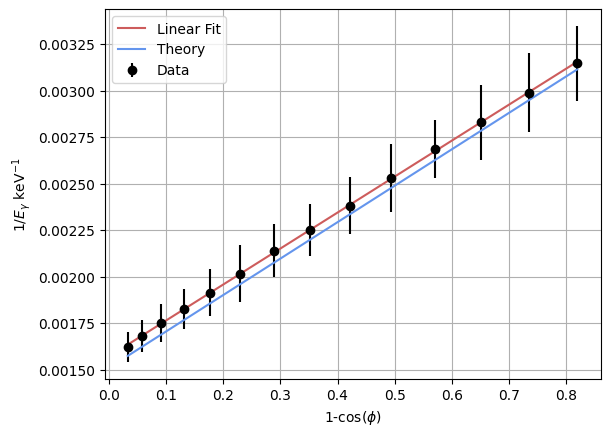

In [77]:
EnergyAnglePlot(path = rootPath + r"/LabWork/Data/dataPart1.txt")